# Ingest and process data

This notebook loads the data that was stored on Box, and converts it to dataframe and dataset with a common format across all collections.

It provides functionality for downlaoding images.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from tools.weaving_tools import NMSCollection, SMGCollection, BTCollection, VACollection
from pathlib import Path
import pandas as pd

In [3]:
nms = NMSCollection(device='mps',img_folder='nms_imgs')
nms.load_original_csvs(files=list(Path('data').glob('NMS_*.*')))
nms.save_csv('data/NMS.csv')

In [4]:
smg = SMGCollection(device='mps', img_folder='smg_imgs')
smg.load_from_json('data/smg_objects_06_06_2022.json')
smg.save_csv('data/SMG.csv')

0it [00:00, ?it/s]

In [5]:
bt = BTCollection(device='mps', img_folder='bt_imgs')
bt.load_from_xml('data/bt_catalogue.xml')
bt.save_csv('data/BT.csv')

  0%|          | 0/58733 [00:00<?, ?it/s]

# Download images

In [6]:
collection = SMGCollection(img_folder=Path('smg_imgs'))
collection.load_from_csv('data/SMG.csv')
collection.fetch_images(n=5)
#collection.save_csv('data/SMG.csv')

before downloading 45090
remaining images to download 104115


  0%|          | 0/5 [00:00<?, ?it/s]

after downloading 45095


In [7]:
collection = BTCollection(img_folder=Path('bt_imgs'))
collection.load_from_csv('data/BT.csv')
collection.fetch_images(n=5)


before downloading 1419


  0%|          | 0/5 [00:00<?, ?it/s]

after downloading 1430


In [8]:
collection = NMSCollection(img_folder=Path('nms_imgs'))
collection.load_from_csv('data/NMS.csv')
collection.fetch_images(n=5)


  0%|          | 0/286 [00:00<?, ?it/s]

# Create vector database

## Vectorize image and text in each collection

In [9]:
# clip_ckpt = 'clip-ViT-B-32'#'openai/clip-vit-base-patch32'

In [10]:
# nms = NMSCollection(device='mps',img_folder='nms_imgs')
# nms.load_from_csv('data/NMS.csv')
# nms.vectorize_collection(clip_ckpt, modalities= [('img_path','image')])

In [11]:
# smg = SMGCollection(device='mps',img_folder='smg_imgs')
# smg.load_from_csv('data/SMG.csv')
# # temp to for testing purposes remove later
# smg.df = smg.df.sample(frac=0.05).reset_index()
# smg.vectorize_collection(clip_ckpt, modalities= [('img_path','image')])

In [12]:
# bt = BTCollection(device='mps', img_folder='bt_imgs')
# bt.load_from_csv('data/BT.csv')
# bt.vectorize_collection(clip_ckpt, modalities= [('img_path','image')])

In [13]:
va = VACollection(device='mps', img_folder='va_imgs')
va.load_from_csv('data/VA.csv')
# temp to for testing purposes remove later
#va.df = va.df.sample(frac=0.3).reset_index()
#va.vectorize_collection(clip_ckpt, modalities= [('img_path','image')])

## add URLs

In [14]:
base_url = 'https://framemark.vam.ac.uk/collections/'
postfix = '/full/600,/0/default.jpg'
va.df['img_url'] = va.df.apply(lambda x: f'{base_url}{x.img_loc}{postfix}', axis=1)

In [15]:
va.df['img_url'].iloc[0] 

'https://framemark.vam.ac.uk/collections/2021MW2149/full/600,/0/default.jpg'

In [16]:
smg.df['base_url'] = 'https://coimages.sciencemuseumgroup.org.uk/images/'
smg.df['img_url'] = smg.df.apply(lambda x: f'{x.base_url}{x.img_loc}', axis=1)

In [17]:
smg.df['img_url'].iloc[0] 

'https://coimages.sciencemuseumgroup.org.uk/images/'

In [18]:
nms.df['base_url'] = 'https://www.nms.ac.uk/search.axd?command=getcontent&server=Detail&value='
nms.df['img_url'] = nms.df.apply(lambda x: f'{x.base_url}{x.img_loc}'.strip(), axis=1)

In [19]:
nms.df['img_url'].iloc[0] 

'https://www.nms.ac.uk/search.axd?command=getcontent&server=Detail&value=PF1052768'

In [20]:
bt.df['base_url'] = 'http://www.digitalarchives.bt.com/CalmView/GetImage.ashx?db=Catalog&type=default&fname='
bt.df['img_url'] = bt.df.apply(lambda x: f'{x.base_url}{x.img_loc}', axis=1)

In [21]:
bt.df['img_url'].iloc[0] 

'http://www.digitalarchives.bt.com/CalmView/GetImage.ashx?db=Catalog&type=default&fname='

# Create Vector Database

In [151]:
import chromadb
import json
from tools.embedding_tools import SigLIPEmbedder

In [152]:
checkpoint = 'google/siglip-base-patch16-224'
siglip_embedder = SigLIPEmbedder(checkpoint)

In [153]:
client = chromadb.PersistentClient(path="ce_multimodal_db")

In [154]:
try:
    client.delete_collection(name="ce_multimodal_db")
except Exception as e:
    print(e)

In [155]:
from chromadb.utils.data_loaders import ImageLoader
data_loader = ImageLoader()

In [156]:
collection_db = client.get_or_create_collection(name="ce_multimodal_db", 
                                             metadata={"hnsw:space": "cosine"},
                                            embedding_function=siglip_embedder, 
                                            data_loader=data_loader
                                            )

In [157]:
def batchify(content_list, n=20):
    for i in range(0, len(content_list), n):
        yield np.array(content_list[i:min(i+n,len(content_list))])

In [158]:
# def _is_image_path(self,file_path):
#         # Convert to Path object
#         file_path = Path(str(file_path))
#         # Check if the file extension is in the list of image extensions
#         return file_path.exists() and (file_path.suffix.lower() in self.image_extensions)

In [169]:
from spacy.lang.en import English 
import numpy as np
from tqdm.notebook import tqdm
nlp = English()
nlp.add_pipe('sentencizer')
from keybert import KeyBERT
kw_model = KeyBERT()

def reshape_text_batch(batch, collection):
    
    content = [[b[0],b[1],s,b[3]] 
                       for b in list(batch) 
                           for s in nlp(str(b[2])).sents if len(s) > 10 # str(b[1])+ ', '+
                                  ] # parameter here
    
    metadatas = [{'record_id':e[0],
                 'name':e[1],
                 'img_path': str(e[3]),
                 'input_modality': 'text',
                 'collection': collection
                        }
                    for e in content
                    ]
    content = [str(c[2]) for c in content]
    return content,metadatas

def reshape_keyword_batch(batch, collection):
    
    content = [[b[0],b[1],kw,b[3]] 
                       for b in list(batch) 
                           for kw in set([w[0] for w in kw_model.extract_keywords(
                                   str(b[2]), 
                                   #keyphrase_ngram_range=(1, 1), 
                                   stop_words='english')]) # str(b[1])+ ', '+
                                  ] 
    
    metadatas = [{'record_id':e[0],
                 'name':e[1],
                 'img_path': str(e[3]),
                 'input_modality': 'keyword',
                 'collection': collection
                        }
                    for e in content
                    ]
    content = [str(c[2]) for c in content]
    return content,metadatas


def reshape_image_batch(batch, collection):
    
    content = [str(i) for i in list(batch[:,-1])]
    
    metadatas = [{'record_id':e[0],
                  'name':e[1],
                  'img_path': str(e[3]),
                  'input_modality':'image',
                  'collection': collection
                        }
                    for e in batch
                    ]
    
    return content,metadatas

In [160]:
collection = smg

In [170]:
image_batches = batchify(collection.df[collection.df.downloaded==True][['record_id','name','description','img_path']].sample(n=4000).values.tolist())
text_batches = batchify(collection.df[collection.df.downloaded==True][['record_id','name','description','img_path']].sample(n=4000).values.tolist())
keyword_batches = batchify(collection.df[collection.df.downloaded==True][['record_id','name','description','img_path']].sample(n=4000).values.tolist())

In [171]:
#reshape_image_batch(next(image_batches), collection.collection_name)
#reshape_text_batch(next(text_batches), collection.collection_name)
#reshape_keyword_batch(next(text_batches), collection.collection_name)

(['ligature',
  'glass',
  'spool',
  'cylindrical',
  'brass',
  'copper',
  '1801',
  'holder',
  'bank',
  'sponge',
  'formaldehyde',
  'circular',
  'holder',
  'france',
  'steels',
  'lengths',
  'oxydized',
  'frankish',
  'portrait',
  'engraving',
  'bart',
  '1770',
  'etching',
  'lithotomy',
  'bullet',
  'shanks',
  'ferguson',
  '1850',
  'earl',
  'dial',
  'logic',
  'stanhope',
  'enamel',
  'tiles',
  'grid',
  'board',
  'electricity',
  'mimic',
  '1900',
  'london',
  'needle',
  'frog',
  '1822',
  'mcmx',
  'guilelmo',
  'koerner',
  'bronze',
  'medal',
  'british',
  'wood',
  'veterinary',
  'steel',
  'cautery',
  'tyre',
  'needle',
  'roman',
  'bronze',
  'hamonic',
  'handblown',
  'glass',
  'cylindrical',
  'bottle',
  'pontil',
  'oblique',
  'cylinders',
  'model',
  'models',
  'common',
  '1760',
  'dental',
  'stone',
  'silver',
  'clasp',
  'storage',
  'glass',
  'bottle',
  'english',
  'century',
  '1891',
  '1920',
  'steel',
  'wells',
  'o

In [163]:
collection_db.count()

0

In [164]:
for b in tqdm(image_batches):
    content, metadatas = reshape_image_batch(b,collection.collection_name)
    counter = collection_db.count()
    ids = [str(i) for i in range(counter,counter+len(content))]
    collection_db.add(
        ids = ids,
        uris = content,
        metadatas = metadatas
    )

0it [00:00, ?it/s]

In [165]:
for b in tqdm(text_batches):
    content, metadatas = reshape_text_batch(b, collection.collection_name)
    counter = collection_db.count()
    ids = [str(i) for i in range(counter,counter+len(content))]
    collection_db.add(
        ids = ids,
        documents = content,
        metadatas = metadatas
    )

0it [00:00, ?it/s]

In [172]:
for b in tqdm(keyword_batches):
    content, metadatas = reshape_keyword_batch(b, collection.collection_name)
    counter = collection_db.count()
    ids = [str(i) for i in range(counter,counter+len(content))]
    collection_db.add(
        ids = ids,
        documents = content,
        metadatas = metadatas
    )

0it [00:00, ?it/s]

In [191]:
def plot_query_results(results, collection_df):
    result_df = pd.DataFrame(results['metadatas'][0])
    result_df['similarity'] = 1 - np.array(results['distances'][0])
    top_results = result_df.groupby('record_id')['similarity'].sum().sort_values(ascending=False).index.tolist()
    query_df = collection_df[collection_df['record_id'].isin(top_results)][['record_id','img_path','description']].reset_index()
    fig = plt.figure(figsize=(10, 10))
    columns = 2
    rows = 5
    for i in range(1, columns*rows +1):
            
            img = Image.open(query_df.loc[i-1,'img_path'])

            ax = fig.add_subplot(rows, columns, i,)
            title = f"{query_df.loc[i-1,'record_id']}" # 
            ax.title.set_text(title)
            ax.set_xticks([])
            ax.set_yticks([])
            plt.imshow(img)
    plt.show()
    return query_df
    


In [173]:
collection_db.count()

30518

BTH valve, type A.T.26, serial No. 575, (RMW/J89 - McVitie Weston number), by British Thomson-Houston Company Limited.


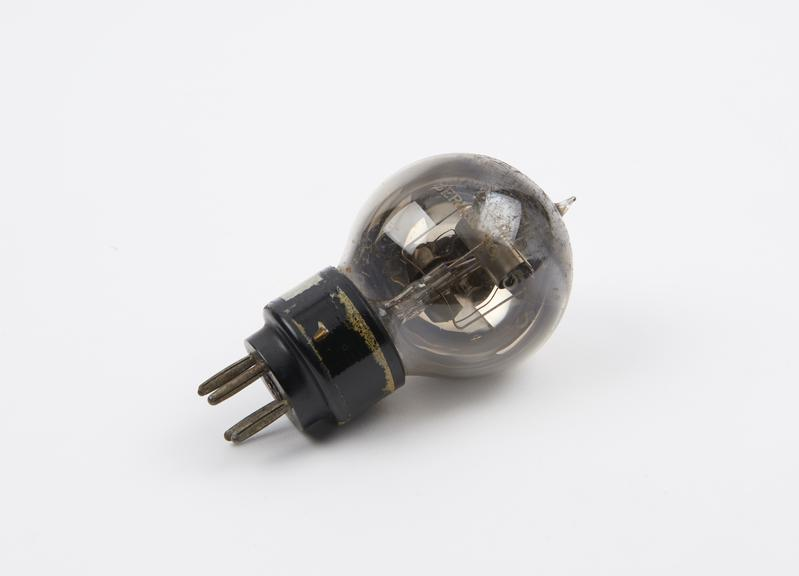

In [204]:
from PIL import Image
idx = 5602
query_img = smg.df[smg.df.downloaded==True].img_path.iloc[idx]
print(smg.df[smg.df.downloaded==True].description.iloc[idx])
Image.open(query_img)

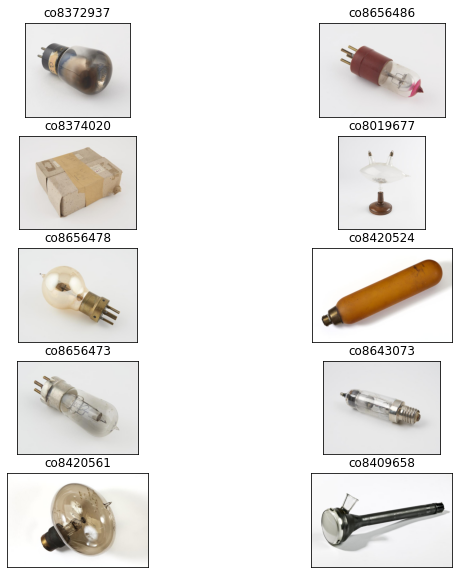

In [202]:
results = collection_db.query(query_uris=[query_img],where={"input_modality": "text"}, n_results=25)
query_df = plot_query_results(results, collection.df)

In [203]:
query_df

,index,record_id,img_path,description
0,11569,co8372937,smg_imgs/456|11|medium_SMG00259811.jpg,"Tungsram valve, type GDG 4100, (RMW/G21 - McVi..."
1,12957,co8656486,smg_imgs/448|681|medium_SMG00237720.jpg,Wade Bequest collection of valves: Cossor P2 t...
2,13024,co8374020,smg_imgs/449|921|medium_SMG00257846.jpg,"Brimar valve, type 7D5, domed envelope, graphi..."
3,24501,co8019677,smg_imgs/422|693|medium_SMG00175471.jpg,Crookes vacuum tube containing a mineral sampl...
4,26798,co8656478,smg_imgs/448|675|medium_SMG00237714.jpg,"Wade Bequest collection of valves: R valve, by..."
5,31170,co8420524,smg_imgs/127|30|medium_cd0699_059_121113_7000_...,Robertson Electric Lamps Ltd bulb for electric...
6,31790,co8656473,smg_imgs/448|673|medium_SMG00237712.jpg,Wade Bequest collection of valves: Mullard ORA...
7,31887,co8643073,smg_imgs/462|687|medium_SMG00279961.jpg,NT46 or NT57 silica triode valve from the earl...
8,41495,co8420561,smg_imgs/127|16|medium_cd0699_045_121113_7000_...,General Electric Co Ltd Osram Axial Type light...
9,42496,co8409658,smg_imgs/209|263|medium_cd0477_012_081219_1996...,"Cathode ray tube, type MW6/2, made by Mullard ..."


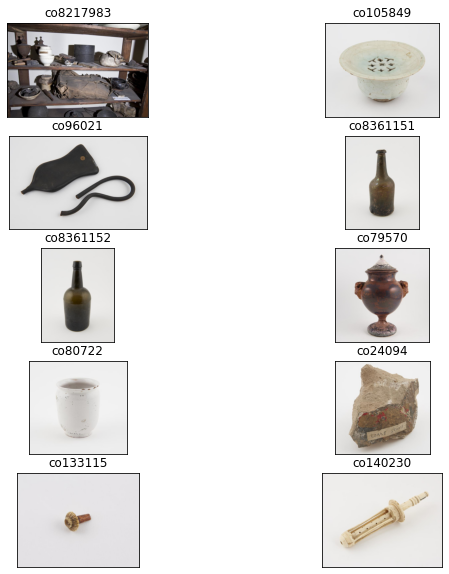

In [137]:
results = collection_db.query(query_uris=[query_img])
#result_df = pd.DataFrame(results['metadatas'][0])
#result_df.head()
plot_query_results(results, collection.df)

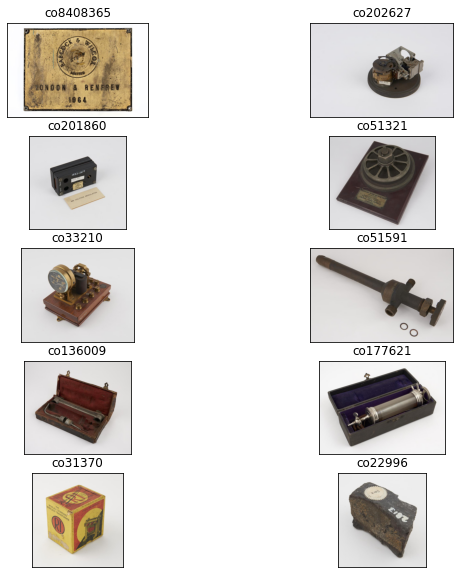

,index,record_id,img_path,description
0,849,co8408365,smg_imgs/203|592|medium_cd0627_021_100723_1994...,"Babcock & Wilcox nameplate, London & Renfrew, ..."
1,1076,co202627,smg_imgs/343|294|medium_SMG00191996.jpg,Timer and spring mounted telemetry transducer ...
2,2167,co201860,smg_imgs/410|490|medium_SMG00194594.jpg,Voltage modulator as used on RAE rocket test v...
3,5404,co51321,smg_imgs/302|800|medium_SMG00022215.jpg,"Air Pump valve, Multiplex Type, mounted on board"
4,5512,co33210,smg_imgs/423|431|medium_SMG00224941.jpg,Non-polarised relay
...,...,...,...,...
95,85711,co446147,smg_imgs/366|292|medium_SMG00075426.jpg,Headlamp mask (10 slots)to fit 7.75 inch diame...
96,88312,co51605,smg_imgs/462|818|medium_SMG00292188.jpg,"Rose's Patent Full Bore Valve, 2"" bore in gunm..."
97,89610,co33164,smg_imgs/425|792|medium_SMG00227678.jpg,Start-stop receiving and transmitting distribu...
98,90804,co118096,smg_imgs/505|721|medium_SMG00189033.jpg,"Porter-Blum electro microtome by Storval, Norw..."


In [208]:

results = collection_db.query(query_texts=["""BTH valve, type A.T.26, serial No. 575, (RMW/J89 - McVitie Weston number), by British Thomson-Houston Company Limited."""],
                             where={"input_modality": "image"},n_results=100)
plot_query_results(results, collection.df)

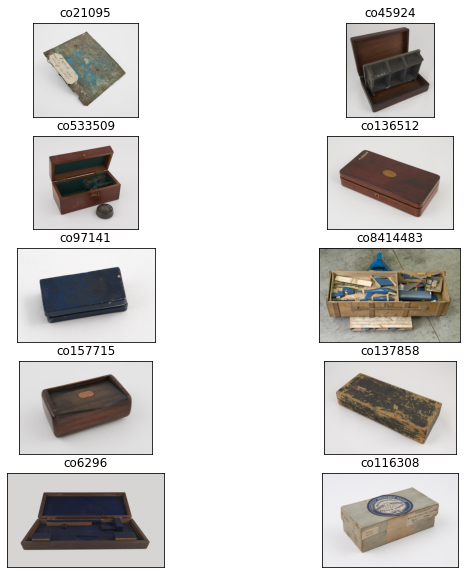

In [150]:

results = collection_db.query(query_texts=["wooden blue box"],
                             where={"input_modality": "image"},n_results=20)
#result_df = pd.DataFrame(results['metadatas'][0])
#result_df.name[10]
#result_df
plot_query_results(results, collection.df)

In [113]:
result_df.shape

(20, 5)

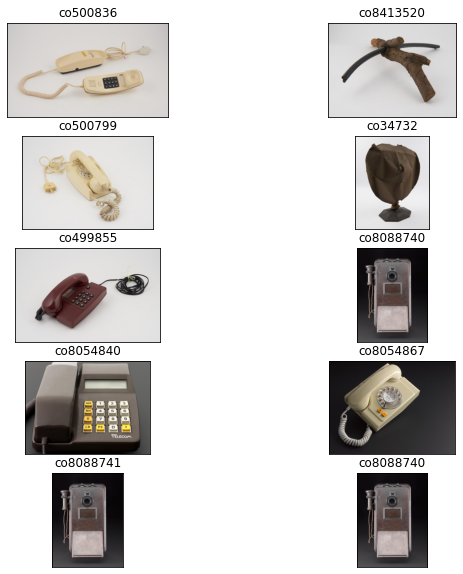

In [114]:
import matplotlib.pyplot as plt
def plot_images(query_df):
        """plot nearest neighbour images"""
        fig = plt.figure(figsize=(10, 10))
        columns = 2
        rows = 5
        for i in range(1, columns*rows +1):
            
            img = Image.open(query_df.loc[i-1,'img_path'])

            ax = fig.add_subplot(rows, columns, i,)
            title = f"{query_df.loc[i-1,'record_id']}" # 
            ax.title.set_text(title)
            ax.set_xticks([])
            ax.set_yticks([])
            plt.imshow(img)
        plt.show()
        
plot_images(result_df)

In [ ]:
# for coll in [nms,bt,smg,va]:
#     for mod in ['image']:
#         coll.add_embeddings_to_database(collection,mod)

In [ ]:
collection.count()

## Fin.